In [102]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler,OneHotEncoder
from xgboost import XGBClassifier
import pathlib
import glob
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.base import TransformerMixin, BaseEstimator
import pandas as pd
import matplotlib.pyplot as plt

In [103]:
dir_path = pathlib.Path('train/')
csv_path = dir_path.joinpath('*.csv')


all_files = glob.glob(csv_path.as_posix())
df=None
for f in all_files:
    if  df is None:
        df = pd.read_csv(f)
    else:
        df = pd.concat([df,pd.read_csv(f)])
# df = df.drop(['market cap','volume','operating cash flow'],axis=1)

In [104]:
df.head(1)

,Stock_code,market_cap,price_per_sale,current_price,price_per_book,return_on_assets,return_on_equity,revenue_per_share,quarterly_revenue_growth,total_cash_per_share,...,book_value_per_dollar,earnings_per_dollar,revenue_per_dollar,price_to_free_cash_flow,sp_52_week_change,stock_52_week_change,FCF_yield,EV_/_FCF,missing,trend_sp
0,A,13190000,2.39,32.27,3.55,13.2,34.26,12.408,17.0,5.503,...,117411598,86877744,157139802,17.776256,8.85,-1.55,0.058379,17.129357,0,True


In [105]:
df.shape

(16225, 29)

In [106]:
# filtered_df = df[filtered_features]

In [107]:
# With all features
numerical_cols = df.select_dtypes('number').columns
id_feature = ['Stock_code']
categorical_cols = df.select_dtypes(exclude = ['number','boolean']).columns.drop(['Stock_code'])
target_feature = ['trend_sp']

In [108]:
# numerical_cols = filtered_df.select_dtypes('number').columns
# id_feature = ['Stock code']
# categorical_cols = df.select_dtypes(exclude = 'number').columns.drop(['Stock code','trend'])
# target_feature = ['trend']

In [109]:
X = df.drop(target_feature + id_feature,axis=1)
y = df[target_feature]

In [110]:
# # With filtered features
# X = df[filtered_features]

In [111]:
print(X.shape, y.shape)

(16225, 27) (16225, 1)


In [112]:
X.columns

Index(['market_cap', 'price_per_sale', 'current_price', 'price_per_book',
       'return_on_assets', 'return_on_equity', 'revenue_per_share',
       'quarterly_revenue_growth', 'total_cash_per_share', 'debt_equity_ratio',
       'book_value_per_share', 'operating_cash_flow', 'volume',
       'Price_per_Earnings_ratio', 'earnings_per_shares', 'sector', 'industry',
       'total_cash_per_dollar', 'book_value_per_dollar', 'earnings_per_dollar',
       'revenue_per_dollar', 'price_to_free_cash_flow', 'sp_52_week_change',
       'stock_52_week_change', 'FCF_yield', 'EV_/_FCF', 'missing'],
      dtype='object')

In [113]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

In [114]:
class Debug(BaseEstimator, TransformerMixin):

    def transform(self, X):
        print(X.shape)
        display(pd.DataFrame(X))
#         self.shape = shape
        # what other output you want
        return X

    def fit(self, X, y=None, **fit_params):
        return self

In [115]:
# Preprocessing for numerical data
numerical_transformer =  Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='median')),
    ('std', StandardScaler())
])
# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant',fill_value='nan')),
    ('oe', OrdinalEncoder())
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [116]:
model = XGBClassifier(n_estimators=100)

In [117]:
# Bundle preprocessing and modeling code in a pipeline
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
#                               ("debug", Debug()),
                              ('model', model)
                             ])

In [118]:
X_train_after = preprocessor.fit_transform(X_train)
X_test_after = preprocessor.transform(X_test)

In [119]:
model.fit(X_train_after,y_train)

/home/timmy/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/timmy/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[12:07:40] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [120]:
y_train_hat = model.predict(X_train_after)
y_test_hat = model.predict(X_test_after)

In [121]:
print(accuracy_score(y_train, y_train_hat))
print(accuracy_score(y_test, y_test_hat))


0.9360746676058819
0.6440016433853739


In [122]:
from sklearn.inspection import permutation_importance
perm_importance = permutation_importance(model, X_test_after, y_test)

Text(0.5, 0, 'Permutation Importance')

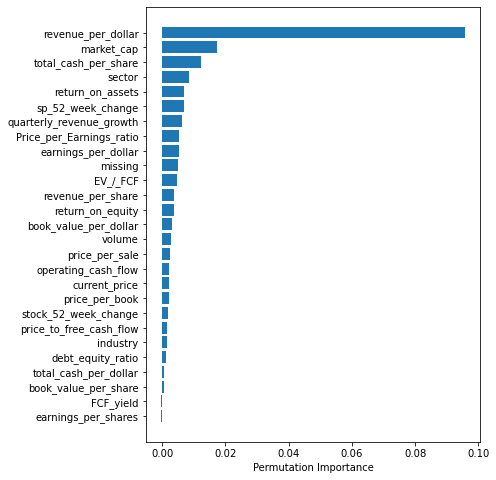

In [123]:
sorted_idx = perm_importance.importances_mean.argsort()
plt.figure(figsize=(6,8))
plt.barh(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

Text(0.5, 0, 'Model Importance')

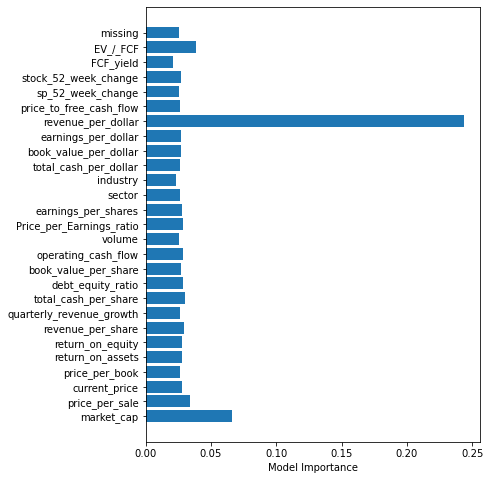

In [124]:
plt.figure(figsize=(6,8))
plt.barh(X.columns, model.feature_importances_)
plt.xlabel("Model Importance")

In [126]:
filtered_features = X.columns[sorted_idx][3:]
filtered_features

Index(['total_cash_per_dollar', 'debt_equity_ratio', 'industry',
       'price_to_free_cash_flow', 'stock_52_week_change', 'price_per_book',
       'current_price', 'operating_cash_flow', 'price_per_sale', 'volume',
       'book_value_per_dollar', 'return_on_equity', 'revenue_per_share',
       'EV_/_FCF', 'missing', 'earnings_per_dollar',
       'Price_per_Earnings_ratio', 'quarterly_revenue_growth',
       'sp_52_week_change', 'return_on_assets', 'sector',
       'total_cash_per_share', 'market_cap', 'revenue_per_dollar'],
      dtype='object')

In [212]:
filtered_features = ['Price per Earnings ratio', 'total cash per dollar', 'sector',
       'debt equity ratio', 'missing', 'quarterly revenue growth',
       'total cash per share', 'earnings per shares', 'stock 52 week change',
       'earnings per dollar', 'price per sale', 'revenue per share',
       'return on equity', 'industry', 'volume', 'return on assets',
       'market cap']